In [ ]:
## This will connect your Google drive with your Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install vaderSentiment

# Import necessary packages

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, accuracy_score


# Part 1

## Reading in train and test files

In [ ]:
# import the data into a dataframe df
df = pd.read_csv('/content/drive/Shareddrives/CS74/Project2/train.csv')

test_df = pd.read_csv('/content/drive/Shareddrives/CS74/Project2/test.csv')

excluded_col = ['reviewTime', 'reviewerID', 'summary', 'reviewerName', 'unixReviewTime', 'image', 'style', 'asin', 'vote', 'category', 'verified']
text_col = 'reviewText'

df['reviewText'] = df['reviewText'] + df['summary']
test_df['reviewText'] = test_df['reviewText'] + test_df['summary']


#drop excluded columns
df = df.drop(columns=excluded_col)
test_df = test_df.drop(columns=excluded_col)

#handle NaN values
df[text_col].fillna('', inplace=True)
test_df[text_col].fillna('', inplace=True)

# df['vote'].fillna(0, inplace=True)
# test_df['vote'].fillna(0, inplace=True)

#make overall reviews binary
df['overall'] = df['overall'].apply(lambda x: 0 if x<=3 else 1)

y_train = df['overall']
df = df.drop('overall', axis=1)
print(df.columns)
print(df.head())
print(y_train)

Index(['reviewText', 'id'], dtype='object')
                                          reviewText   id
0  all of the reviews for this product are fake.A...  ab0
1                     wrong part. our fault.One Star  ab1
2           this wire set it really sucks!!!One Star  ab2
3  first use, it leaked instantly. even at 5 buck...  ab3
4                                 didn't fitOne Star  ab4
0        0
1        0
2        0
3        0
4        0
        ..
29184    1
29185    1
29186    1
29187    1
29188    1
Name: overall, Length: 29189, dtype: int64


## Text preprocessing

We will use an approach similar to bag of words to train our model. This means that we need to separate the review text into individual words, and then have columns in the dataframe for each unique word, with the count of the word for each review.

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=1500)

word_counts = vectorizer.fit_transform(df[text_col].tolist())
word_counts_df = pd.DataFrame(word_counts.toarray(), columns=vectorizer.get_feature_names_out())
text_df = pd.concat([df, word_counts_df], axis=1)

test_word_counts = vectorizer.fit_transform(test_df[text_col].tolist())
test_word_counts_df = pd.DataFrame(test_word_counts.toarray(), columns=vectorizer.get_feature_names_out())
test_text_df = pd.concat([test_df, test_word_counts_df], axis=1)

## Cleaning up training data


In [ ]:
X_train = text_df.drop(text_col, axis=1)
X_train = X_train.drop('id', axis=1)
#y_train defined earlier

X_test = test_text_df.drop(text_col, axis=1)
X_test = X_test.drop('id', axis=1)

#merge missing columns

all_col = X_test.columns.tolist() + X_train.columns.tolist()
X_train = X_train.reindex(columns=all_col, fill_value=0)
X_test = X_test.reindex(columns=all_col, fill_value=0)

print(X_train.head(), X_test.head())

    10  100   11   12   15  16   20   30   50  70  ...  you need  you re  \
0  0.0  0.0  0.0  0.0  0.0   0  0.0  0.0  0.0   0  ...       0.0     0.0   
1  0.0  0.0  0.0  0.0  0.0   0  0.0  0.0  0.0   0  ...       0.0     0.0   
2  0.0  0.0  0.0  0.0  0.0   0  0.0  0.0  0.0   0  ...       0.0     0.0   
3  0.0  0.0  0.0  0.0  0.0   0  0.0  0.0  0.0   0  ...       0.0     0.0   
4  0.0  0.0  0.0  0.0  0.0   0  0.0  0.0  0.0   0  ...       0.0     0.0   

   you want  you want to  you will  young  your  your money  your phone  \
0       0.0          0.0       0.0    0.0   0.0         0.0         0.0   
1       0.0          0.0       0.0    0.0   0.0         0.0         0.0   
2       0.0          0.0       0.0    0.0   0.0         0.0         0.0   
3       0.0          0.0       0.0    0.0   0.0         0.0         0.0   
4       0.0          0.0       0.0    0.0   0.0         0.0         0.0   

   yourself  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0  

[5 rows

## Cross validation of different models

### Logistic Regression

[[15448  2330]
 [ 2878  8533]] 0.8083631805579558 0.8109674224180639 0.821576621329953


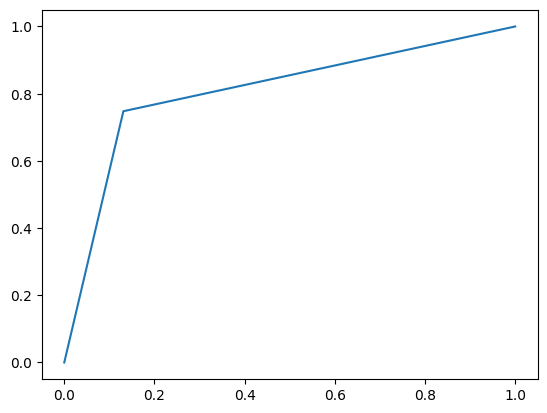

In [ ]:
model1 = LogisticRegression()

model1.fit(X_train, y_train)
predictions = model1.predict(X_test)

submission = pd.DataFrame({'preds': predictions, 'id': test_df['id']})

submission.to_csv('/content/drive/Shareddrives/CS74/Project2/text_only-2.csv', index=False)



predicted1 = cross_val_predict(model1, X_train, y_train, cv=5)
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_train, predicted1)

# Calculate ROC curve and AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, predicted1)
plt.plot(false_positive_rate, true_positive_rate)

roc_auc = roc_auc_score(y_train, predicted1)

# Calculate macro F1 score
macro_f1 = f1_score(y_train, predicted1, average='macro')

# Calculate accuracy
accuracy = accuracy_score(y_train, predicted1)

print(conf_matrix, roc_auc, macro_f1, accuracy)




### Naive Bayes

[[13424  4354]
 [ 2492  8919]] 0.7683523966247504 0.7597363878209673 0.7654595909417932


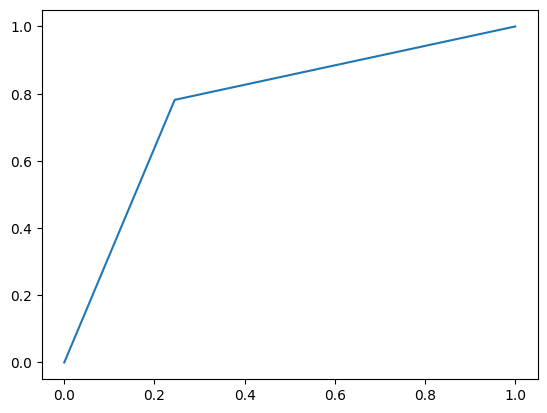

In [ ]:
model2 = GaussianNB()
model2.fit(X_train, y_train)
predictions = model2.predict(X_test)

submission = pd.DataFrame({'preds': predictions, 'id': test_df['id']})

submission.to_csv('/content/drive/Shareddrives/CS74/Project2/text_only-2.csv', index=False)
predicted2 = cross_val_predict(model2, X_train, y_train, cv=5)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_train, predicted2)

# Calculate ROC curve and AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, predicted2)
plt.plot(false_positive_rate, true_positive_rate)

roc_auc = roc_auc_score(y_train, predicted2)

# Calculate macro F1 score
macro_f1 = f1_score(y_train, predicted2, average='macro')

# Calculate accuracy
accuracy = accuracy_score(y_train, predicted2)

print(conf_matrix, roc_auc, macro_f1, accuracy)

### KNearestNeighbors

In [ ]:
model3 = KNeighborsClassifier()
model3.fit(X_train, y_train)
predictions = model3.predict(X_test)
# submission = pd.DataFrame({'preds': predictions, 'id': test_df['id']})

predicted3 = cross_val_predict(model3, X_train, y_train, cv=5)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_train, predicted3)

# Calculate ROC curve and AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, predicted3)
plt.plot(false_positive_rate, true_positive_rate)

roc_auc = roc_auc_score(y_train, predicted3)

# Calculate macro F1 score
macro_f1 = f1_score(y_train, predicted3, average='macro')

# Calculate accuracy
accuracy = accuracy_score(y_train, predicted3)

print(conf_matrix, roc_auc, macro_f1, accuracy)


# Part 2

## Do Sentiment Analysis

In [ ]:
analyzer = SentimentIntensityAnalyzer()


df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in df['reviewText']]
df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in df['reviewText']]
df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in df['reviewText']]
df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in df['reviewText']]

test_df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in test_df['reviewText']]
test_df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in test_df['reviewText']]
test_df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in test_df['reviewText']]
test_df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in test_df['reviewText']]

## Clean Up Training Data

In [ ]:
to_exclude = ['reviewText']

sent_df = df.drop(columns=to_exclude)
test_sent_df = test_df.drop(columns=to_exclude)

X_train_sent = sent_df.drop('id', axis=1)
X_test_sent = test_sent_df.drop('id', axis=1)

## Train and Run Logistic Regression

reviewText    wrong part. our fault.One Star
id                                       ab1
compound                             -0.4767
pos                                      0.0
neg                                    0.437
neu                                    0.563
Name: 1, dtype: object
True         0
Predicted    1
Name: 15, dtype: int64
[[14927  2851]
 [ 4650  6761]] 0.7160658604881978 0.7211985995439163 0.7430196306827914


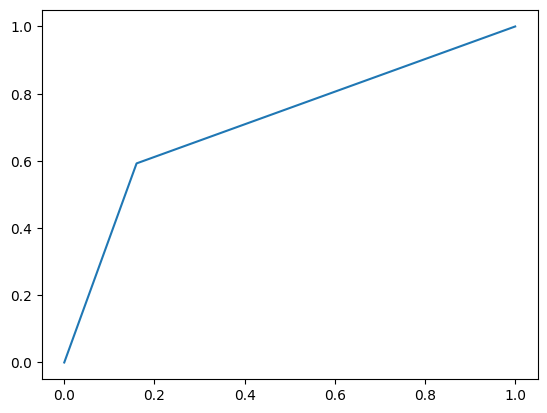

In [ ]:
model = LogisticRegression(max_iter=200)

# just use a logistic regression
model.fit(X_train_sent, y_train)
predictions = model.predict(X_test_sent)


predicted1 = cross_val_predict(model, X_train_sent, y_train, cv=5)
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_train, predicted1)

# Calculate ROC curve and AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, predicted1)
plt.plot(false_positive_rate, true_positive_rate)

roc_auc = roc_auc_score(y_train, predicted1)

# Calculate macro F1 score
macro_f1 = f1_score(y_train, predicted1, average='macro')

# Calculate accuracy
accuracy = accuracy_score(y_train, predicted1)

print(conf_matrix, roc_auc, macro_f1, accuracy)

## Combine text and sentiment data

In [ ]:
X_train_combo = pd.concat([X_train, X_train_sent], axis=1)
X_test_combo = pd.concat([X_test, X_test_sent], axis=1)

## Train Log Regression on Text and Sentiment Data

In [ ]:
model = LogisticRegression(max_iter=200)

model.fit(X_train_combo, y_train)
predictions = model.predict(X_test_combo)

submission = pd.DataFrame({'preds': predictions, 'id': test_df['id']})

submission.to_csv('/content/drive/Shareddrives/CS74/Project2/text_w_sentiment.csv', index=False)

predicted1 = cross_val_predict(model, X_train_combo, y_train, cv=5)
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_train, predicted1)

# Calculate ROC curve and AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, predicted1)
plt.plot(false_positive_rate, true_positive_rate)

roc_auc = roc_auc_score(y_train, predicted1)

# Calculate macro F1 score
macro_f1 = f1_score(y_train, predicted1, average='macro')

# Calculate accuracy
accuracy = accuracy_score(y_train, predicted1)

print(conf_matrix, roc_auc, macro_f1, accuracy)